# Lab 3: Transfer Learning

In this lab, we will explore the power of **Transfer Learning**.

We will try to classify images of **Ants** and **Bees**.
The dataset is very small (only about 120 training images for each class). 

**The Plan:**
1.  **Train from Scratch:** We will first try to train a simple custom Convolutional Neural Network (CNN) from scratch. We will see that it struggles.
2.  **Transfer Learning:** We will then use a pre-trained **ResNet18** model (trained on ImageNet) and fine-tune it. We will see huge improvements.

**Note:** Ensure your Runtime type is set to **GPU** (Runtime -> Change runtime type -> Hardware accelerator -> T4 GPU).

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import time
import copy
from urllib.request import urlretrieve
import zipfile
import random

# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random Seed for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("Random seed set to 42")

Using device: cpu
Random seed set to 42


## 1. Data Preparation

We will download the `hymenoptera_data` dataset.

In [39]:
# Function to download and extract data
def setup_data(data_dir="./hymenoptera_data"):
    if os.path.exists(data_dir):
        print("Data already exists.")
        return

    print("Downloading data...")
    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
    filename = "hymenoptera_data.zip"
    urlretrieve(url, filename)

    print("Extracting data...")
    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall(".")
    print("Done!")

setup_data()

Data already exists.


In [40]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Class names: {class_names}")
print(f"Training set size: {dataset_sizes['train']}")
print(f"Validation set size: {dataset_sizes['val']}")

Class names: ['ants', 'bees']
Training set size: 244
Validation set size: 153


In [41]:
# Check Class Balance
print("Training Class Balance:")
train_targets = image_datasets['train'].targets
train_class_counts = {class_names[i]: train_targets.count(i) for i in range(len(class_names))}
print(train_class_counts)

print("Validation Class Balance:")
val_targets = image_datasets['val'].targets
val_class_counts = {class_names[i]: val_targets.count(i) for i in range(len(class_names))}
print(val_class_counts)

Training Class Balance:
{'ants': 123, 'bees': 121}
Validation Class Balance:
{'ants': 70, 'bees': 83}


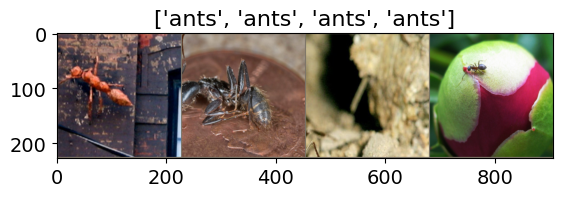

In [42]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [43]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train' and scheduler:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Part 1: Training a Custom CNN from Scratch

Here we define a simple CNN. Since we have very little data (only ~244 train images), a custom model trained from scratch without pre-trained weights often struggles to find good features.

In [44]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Block 1: 224x224 -> 112x112
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        #batch norm
        self.bn1 = nn.BatchNorm2d(16)
        
        # Block 2: 112x112 -> 56x56
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Block 3: 56x56 -> 28x28
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Common layers
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully Connected Layers
        # Calculation: After 3 pools, size is 224 / 2^3 = 28
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2) 

    def forward(self, x):
        # Conv Block 1 and batch norm
        x = self.pool(self.relu(self.conv1(x)))
        x = self.bn1(x)

        
        # Conv Block 2
        x = self.pool(self.relu(self.conv2(x)))
        x = self.bn2(x)
        
        # Conv Block 3
        x = self.pool(self.relu(self.conv3(x)))
        x = self.bn3(x)
        
        # Flatten
        x = x.view(x.size(0), -1) 
        
        # Dense Layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

model_scratch = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

# Train for a few epochs
model_scratch = train_model(model_scratch, criterion, optimizer_scratch, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.9730 Acc: 0.5615
val Loss: 0.8343 Acc: 0.4575

Epoch 1/9
----------
train Loss: 0.7179 Acc: 0.5410
val Loss: 0.6747 Acc: 0.6013

Epoch 2/9
----------
train Loss: 0.7446 Acc: 0.5943
val Loss: 0.8432 Acc: 0.5948

Epoch 3/9
----------
train Loss: 0.7287 Acc: 0.5697
val Loss: 0.6436 Acc: 0.6471

Epoch 4/9
----------
train Loss: 0.7420 Acc: 0.5984
val Loss: 0.6497 Acc: 0.6144

Epoch 5/9
----------
train Loss: 0.6788 Acc: 0.6148
val Loss: 0.8874 Acc: 0.6144

Epoch 6/9
----------
train Loss: 0.7124 Acc: 0.6721
val Loss: 0.6404 Acc: 0.6340

Epoch 7/9
----------
train Loss: 0.7719 Acc: 0.5984
val Loss: 0.7537 Acc: 0.5621

Epoch 8/9
----------
train Loss: 0.6885 Acc: 0.6475
val Loss: 0.6900 Acc: 0.6275

Epoch 9/9
----------
train Loss: 0.6289 Acc: 0.6598
val Loss: 0.6153 Acc: 0.7124

Training complete in 4m 38s
Best val Acc: 0.712418


### Before Adding Batch Normalization :
* Best val Acc: 0.614379

### Observation
Notice that the validation accuracy is likely not improving much or is fluctuating. The model might overfit or just fail to learn robust features because 200 images isn't enough to learn "what includes an ant vs a bee" from raw pixels.

## Part 2: Transfer Learning

Now, let's use **ResNet18** pre-trained on ImageNet. This model has already seen millions of images and knows how to detect edges, textures, and object parts.

We will:
1. Load the pre-trained model.
2. **Freeze** the parameters (so we don't break the pre-trained weights).
3. Replace the final layer (Head) to output 2 classes instead of 1000.

In [45]:
# Load pre-trained ResNet18
model_ft = models.resnet18(weights='DEFAULT')

# Explore the architecture
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Exploring the Architecture
We need to explore the architecture to see what the final layer is called. 

From the print output above, we can see the network ends with: 
`(fc): Linear(in_features=512, out_features=1000, bias=True)`

This tells us:
1. The final layer is named **`fc`**.
2. It has **512** input features.

So we need to:
1. **Freeze** all layers (to keep the pre-trained "knowledge").
2. **Replace** the `fc` layer with a new `nn.Linear(512, 2)` (since we have 2 classes: ants and bees).
3. **Train** only this new `fc` layer.

In [46]:
# FREEZE parameters (Feature Extractor)
# We freeze everything so the gradients don't update the pre-trained weights
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the Head
# In ResNet, the final layer is called 'fc'
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

# Move to device
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# Note: we pass model_ft.fc.parameters(), meaning ONLY the new head is trained! (we can pass all parameters and it will fine-tune the unfrozen layers as well)
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

In [47]:
# Train the Transfer Learning model
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6612 Acc: 0.6803
val Loss: 0.2666 Acc: 0.9150

Epoch 1/9
----------
train Loss: 0.5088 Acc: 0.7623
val Loss: 0.1906 Acc: 0.9281

Epoch 2/9
----------
train Loss: 0.4643 Acc: 0.8156
val Loss: 0.1824 Acc: 0.9412

Epoch 3/9
----------
train Loss: 0.6016 Acc: 0.7787
val Loss: 0.2112 Acc: 0.9281

Epoch 4/9
----------
train Loss: 0.4684 Acc: 0.7951
val Loss: 0.4797 Acc: 0.7908

Epoch 5/9
----------
train Loss: 0.4217 Acc: 0.8074
val Loss: 0.4790 Acc: 0.8366

Epoch 6/9
----------
train Loss: 0.4858 Acc: 0.8115
val Loss: 0.2212 Acc: 0.9346

Epoch 7/9
----------
train Loss: 0.4205 Acc: 0.8033
val Loss: 0.2046 Acc: 0.9346

Epoch 8/9
----------
train Loss: 0.3511 Acc: 0.8320
val Loss: 0.1851 Acc: 0.9608

Epoch 9/9
----------
train Loss: 0.4062 Acc: 0.8648
val Loss: 0.2184 Acc: 0.9346

Training complete in 6m 35s
Best val Acc: 0.960784


### Observation
You should see much higher accuracy (often >90%) very quickly, even within the first few epochs. The pre-trained features are doing most of the work!

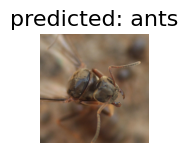

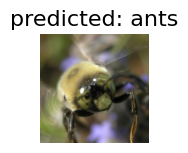

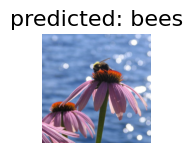

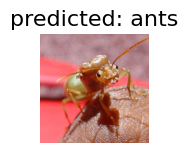

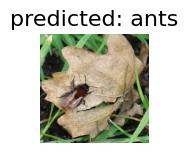

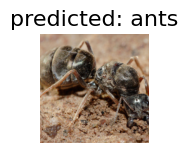

In [48]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)